In [2]:
# Importing necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import calendar
import itertools
from datetime import datetime,date, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
plt.rcParams['figure.figsize'] = [14, 4]
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading data to dataframe
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


# 1. Exploratory Data Analysis (EDA)

### 1.1 Data pre-processing

In [4]:
def data_preprocessing(df):
    """
    Preprocessing the Data for analysis

    Args:
        df (Dataframe): Raw dataframe

    Returns:
        Dataframe: Preprocessed dataframe
    """ 
    
    # Converting the date column into datetime type
    df['date'] = pd.to_datetime(df['Month'])
    #Re-naming columns
    df=df.rename(columns={'#Passengers':'passengers'})
    # Create separate month and year columns
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    # Map numerical months to month names using the calendar module
    df['month'] = df['month'].apply(lambda x: calendar.month_name[x])
    #Droping Month column
    df=df.drop('Month', axis=1)
    return df

In [5]:
data=data_preprocessing(data)

### 1.2 Missing Data Handling

In [6]:
# Checking for null values
data.isnull().sum()

passengers    0
date          0
month         0
year          0
dtype: int64

Note: No missing data found

### 1.3 Time Series Plot

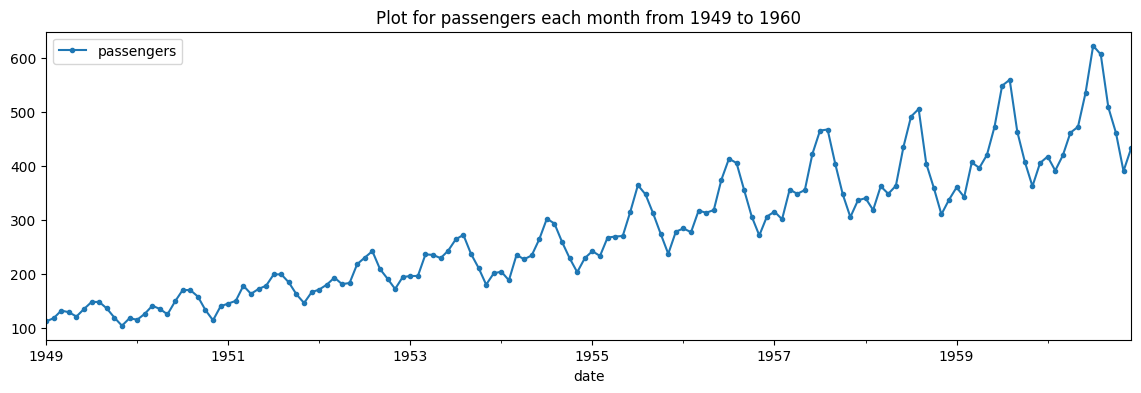

In [7]:
# plotting passengers year wise
data.set_index('date').loc[:,['passengers']].plot(style='.-')
plt.title('Plot for passengers each month from 1949 to 1960')
plt.show()

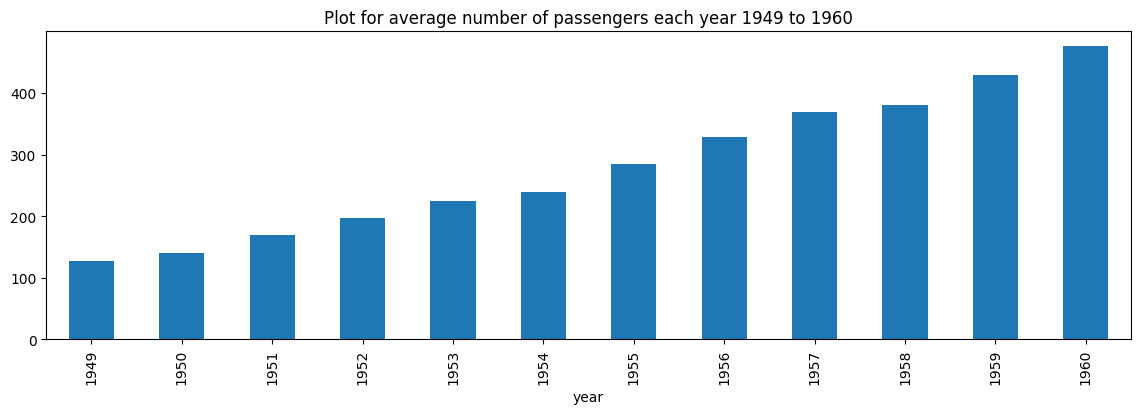

In [8]:
# plotting passengers year wise using bar plot
data.groupby('year')['passengers'].mean().plot(kind='bar')
plt.title('Plot for average number of passengers each year 1949 to 1960')
plt.show()

Note: Number of passangers increases with the increase of years.

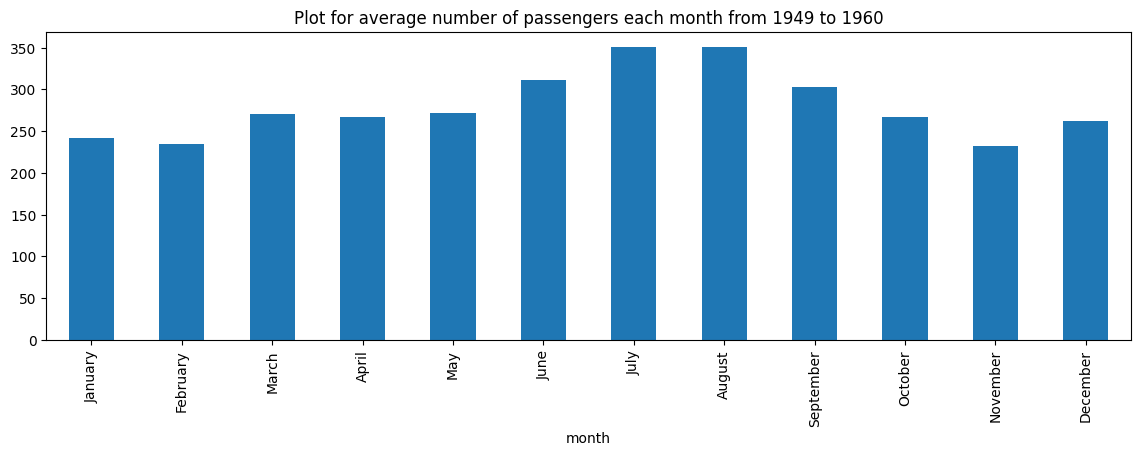

In [9]:
# monthwise passenger travel
data[['passengers','month', 'year']].groupby( ['month'])['passengers'].mean().reindex(index=['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December']).plot(kind='bar');
plt.title('Plot for average number of passengers each month from 1949 to 1960')
plt.show()

Note: Above bar plot shows that the passangers are likely travel more during the months months June to September

### 1.4 Summary Statistics and Metrics

In [10]:
print(data[['passengers','date']].describe())
skewness = pd.Series(data['passengers']).skew()
print('skewness value: ', skewness)
kurtosis = pd.Series(data['passengers']).kurtosis()
print('kurtosis value: ',kurtosis)

       passengers                 date
count  144.000000                  144
mean   280.298611  1954-12-16 05:00:00
min    104.000000  1949-01-01 00:00:00
25%    180.000000  1951-12-24 06:00:00
50%    265.500000  1954-12-16 12:00:00
75%    360.500000  1957-12-08 18:00:00
max    622.000000  1960-12-01 00:00:00
std    119.966317                  NaN
skewness value:  0.5831604861560892
kurtosis value:  -0.3649418621454963


Observation:
1. mean=280.298611 this means that data is distributed around this value.

2. Standard Deviation: A measure of the dispersion or spread of the data around the mean. A higher standard deviation indicates greater variability in the data.

3. The range of the data points are between 104 and 622.

4. The mean value is close to the median, this indicates that the distribution is roughly symmetric.

5. A skewness value of 0.5 indicates that the data distribution is skewed to the right, but the skewness is not extremely high. It suggests that the tail on the right side of the distribution is longer than the tail on the left side, but the skewness is not severe.

6. A kurtosis value of -0.3 is not extremely negative, which suggests that the distribution's tails are only slightly lighter than those of a normal distribution. It indicates that the data is closer to a normal distribution in terms of the tails' shape, compared to a distribution with positive kurtosis.

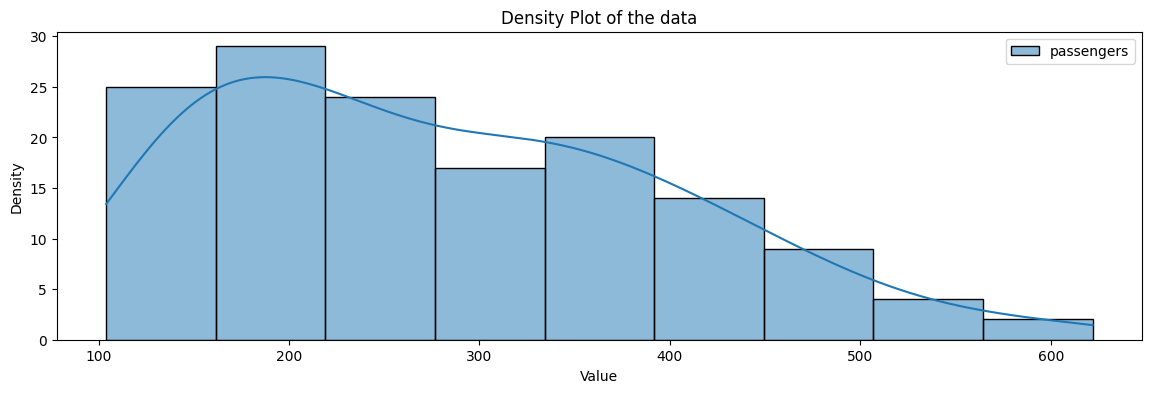

In [11]:
df1=data.loc[:,['passengers', 'date']].set_index('date')
# Create a density plot using Seaborn
plt.title('Density Plot of the data')
sns.histplot(df1, kde=True, color='blue')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

### 1.5 Checking for Seasonality and Cyclic patterns

**1.5.1 Seasonal decomposition**

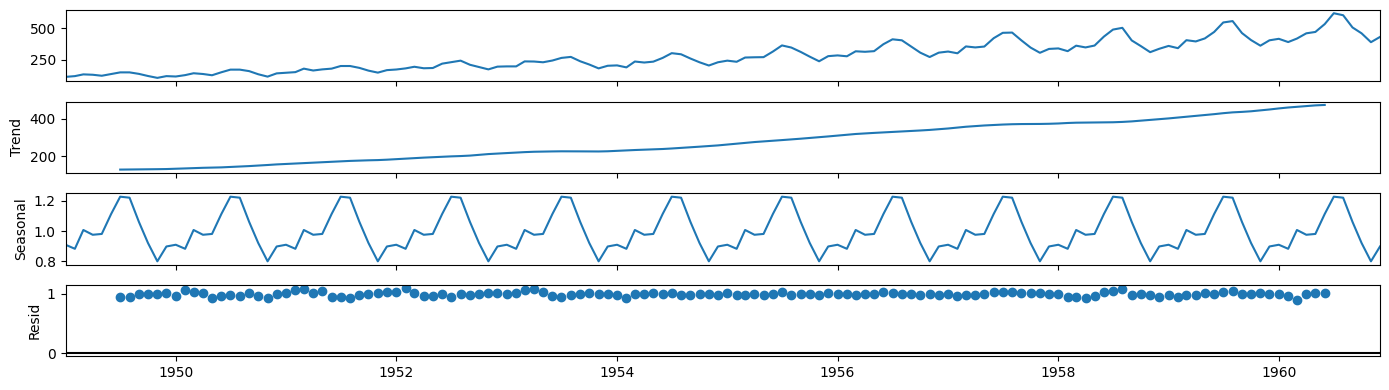

In [12]:
ses_dec_multi = seasonal_decompose(df1, model='multiplicative', period=12).plot()

Observation:
1. A seasonal pattern exists in the data since the rises and falls are of fixed period and in the same pattern.

2. There is no cyclic pattern exists in the data, since the rises and falls that are of fixed period. If the cyclic pattern    exists in the data, the duration of these fluctuations is usually of at least 2 years.

3. This timeseries has trend as well as seasonality so the series is not stationary.

### 1.6 Checking for anomalies

**1.6.1 Visual Inspection**

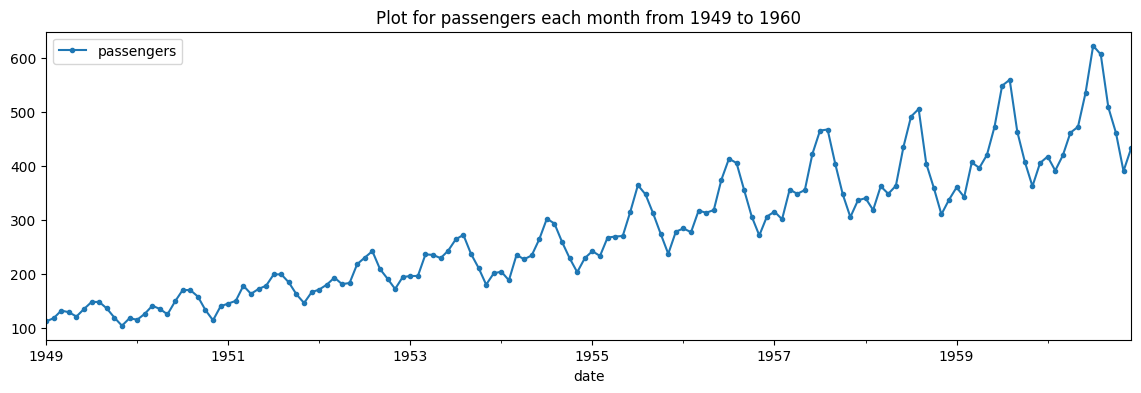

In [13]:
data.set_index('date').loc[:,['passengers']].plot(style='.-')
plt.title('Plot for passengers each month from 1949 to 1960')
plt.show()

Note: From visual inspection no anomolies found

**1.6.2 Modified z-score method**

In [14]:
# Calculate mean and standard deviation
mean = np.mean(data['passengers'])
std_dev = np.std(data['passengers'])
# Set threshold for identifying anomalies (e.g., 2 or 3)
threshold = 2
# Calculate the modified z-scores
modified_z_scores = [0.6745 * (x - mean) / std_dev for x in data['passengers']]
# Identify indices of anomalies
anomalies_indices = np.where(np.abs(modified_z_scores) > threshold)[0]
# Identify the values of anomalies
anomalies_values = [data['passengers'][i] for i in anomalies_indices]
print("Anomalies:", anomalies_values)


Anomalies: []


Note: From modified z-score method also no Anomalies found

# 2. Preprocessing:

Handle missing values if any. Consider and justify any transformations or differencing of the data.

**2.1 Testing for stationary**

In [15]:
print("Observations of Dickey-fuller test")
dftest = adfuller(df1,autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

p_value = dfoutput[1]
if p_value <= 0.05:
    print("The series is likely stationary.")
else:
    print("The series is likely non-stationary.")


Observations of Dickey-fuller test
Test Statistic                   0.815369
p-value                          0.991880
#lags used                      13.000000
number of observations used    130.000000
critical value (1%)             -3.481682
critical value (5%)             -2.884042
critical value (10%)            -2.578770
dtype: float64
The series is likely non-stationary.


Note:
The Dickey-Fuller unit root test test shows that the time series is not stationary which is already seen in the seasonal decomposition plot as well. Lets apply different transformations to make the time series stationary.

**2.1.1. Differencing, log transformation and box-cox Transformation**



In [16]:
# First-order differencing
df1['first_diff'] = df1.diff().dropna()
# Log transformation
df1['log_transform'] = np.log(df1['passengers'])
# Apply Box-Cox transformation
transformed_data, lambda_value = boxcox(df1['passengers'])
df1['boxcox_transform']=transformed_data
df1=df1.fillna(0)

In [17]:
df1.head()

,passengers,first_diff,log_transform,boxcox_transform
date,,,,
1949-01-01,112,0.0,4.718499,6.827490
1949-02-01,118,6.0,4.770685,6.932822
1949-03-01,132,14.0,4.882802,7.161892
1949-04-01,129,-3.0,4.859812,7.114611
1949-05-01,121,-8.0,4.795791,6.983787


**2.1.2. Testing stationary for first difference**

In [18]:
print("Observations of Dickey-fuller test")
dftest = adfuller(df1['first_diff'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

p_value = dfoutput[1]
if p_value <= 0.05:
    print("The data is likely stationary.")
else:
    print("The data is likely non-stationary.")


Observations of Dickey-fuller test
Test Statistic                  -2.889186
p-value                          0.046620
#lags used                      12.000000
number of observations used    131.000000
critical value (1%)             -3.481282
critical value (5%)             -2.883868
critical value (10%)            -2.578677
dtype: float64
The data is likely stationary.


**2.1.3. Testing stationary for log transformation**

In [19]:
print("Observations of Dickey-fuller test")
dftest = adfuller(df1['log_transform'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

p_value = dfoutput[1]
if p_value <= 0.05:
    print("The data is likely stationary.")
else:
    print("The data is likely non-stationary.")


Observations of Dickey-fuller test
Test Statistic                  -1.717017
p-value                          0.422367
#lags used                      13.000000
number of observations used    130.000000
critical value (1%)             -3.481682
critical value (5%)             -2.884042
critical value (10%)            -2.578770
dtype: float64
The data is likely non-stationary.


**2.1.4. Testing stationary for box-cox transformation**

In [20]:
print("Observations of Dickey-fuller test")
dftest = adfuller(df1['boxcox_transform'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

p_value = dfoutput[1]
if p_value <= 0.05:
    print("The data is likely stationary.")
else:
    print("The data is likely non-stationary.")


Observations of Dickey-fuller test
Test Statistic                  -1.326071
p-value                          0.617162
#lags used                      13.000000
number of observations used    130.000000
critical value (1%)             -3.481682
critical value (5%)             -2.884042
critical value (10%)            -2.578770
dtype: float64
The data is likely non-stationary.


**2.2. Visualization of the time series with all the transformations** 

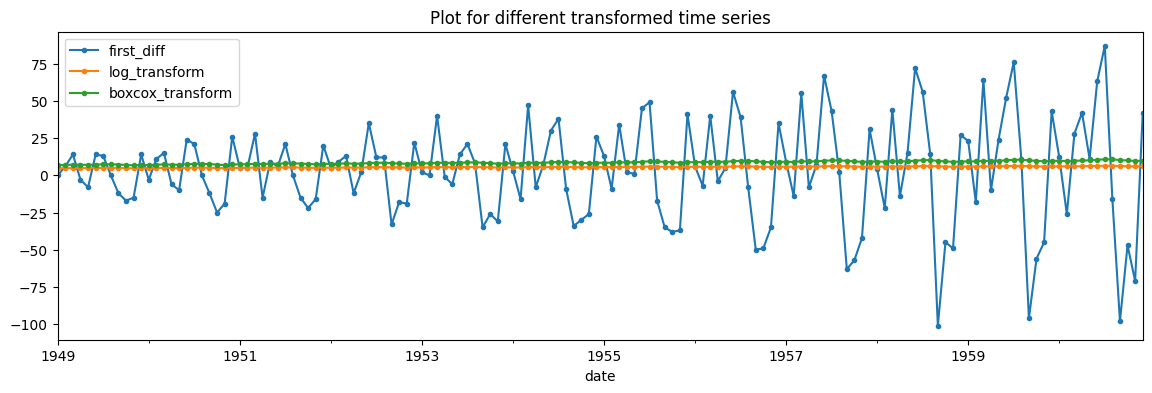

In [21]:
df1.loc[:,['first_diff', 'log_transform', 'boxcox_transform']].plot(style='.-')
plt.title('Plot for different transformed time series')
plt.show()

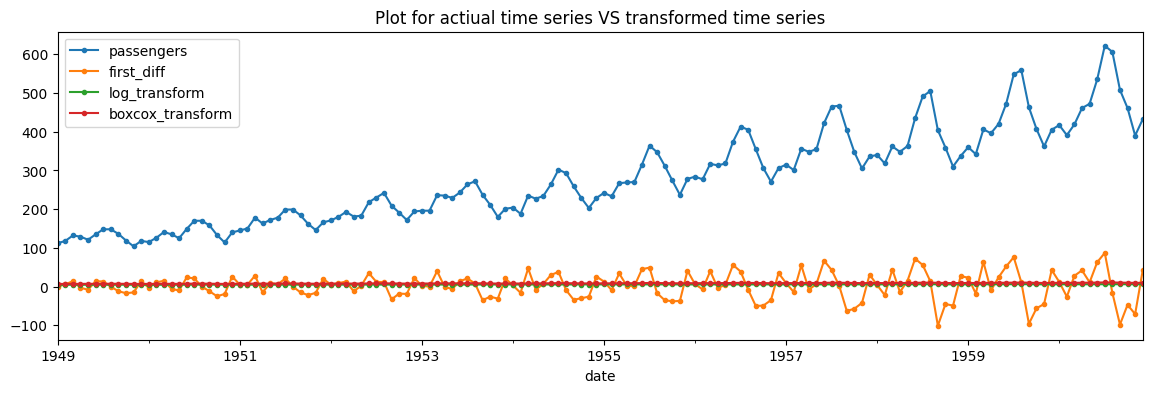

In [22]:
df1.loc[:,['passengers', 'first_diff', 'log_transform', 'boxcox_transform']].plot(style='.-')
plt.title('Plot for actiual time series VS transformed time series')
plt.show()

Observation:

    1. All of the above transformations only the first difference make the time series stationary. This can be observed from above tests as well as visual plot.

# 3.Model Building:

Split the data into a training set and a test set. Justify your choice of split ratio. Implement different forecasting models. Provide detailed commentary on the reasons for selecting each model, the underlying assumptions, and their strengths and weaknesses.

In [23]:
df1.head()

,passengers,first_diff,log_transform,boxcox_transform
date,,,,
1949-01-01,112,0.0,4.718499,6.827490
1949-02-01,118,6.0,4.770685,6.932822
1949-03-01,132,14.0,4.882802,7.161892
1949-04-01,129,-3.0,4.859812,7.114611
1949-05-01,121,-8.0,4.795791,6.983787


In [24]:
ts_df=df1[['passengers']]

**3.1 Train and Test split**

In [25]:
# Splitting train and test data in 132:12 ratio.
train=ts_df[:132]
test=ts_df[132:]

Note:

I am splitting first 132 data points(11 years of data) for training and last 12 data points(one year of data) for testing. The observations at one time point are correlated with the observations at nearby time points,this means that this correlation can arise due to seasonality, trends, and other patterns inherent in time series data, so we can not randomly split the data for training and testing purpose.

# 4 ARIMA Model

Here I am going to fit and evaluate and compare the forecased values from two models ARIMA and SARIMA. However, from the seasonal decomposition plot we have already seen that the time series data has seasonality so the SARIMA model will fit best in this case.Lets check the results below:

ARIMA model has 3 components
1. Auto regression(AR): This means its regression to its past values. How many past values can be used to predict the series is called the order of AR model. 
    
    
2. Moving Average(MA):This tells us that the present value of time series is dependent not only on the past values but also on the errors of the past values.How many previous errors from the lagged values can be used to predict the series is the order of MA. 
    
    
3. Integrated: While we differencing the original series the original series is changed. So, Integration stands for integrating the differentiated series to go back to the original series.  

Note:
1. Here I am fitting the ARIMA model with the order of (2,1,2). I choose these values of p,d,q by using custom for loop method(method 3 described below). Initially I fit the model with any random p,d,q values and the choose the order of p,d,q corrosponding the lowest RMSE value.

**4.1 Fitting ARIMA Model**

In [26]:
train

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1959-08-01,559
1959-09-01,463
1959-10-01,407


In [27]:
test

,passengers
date,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


In [28]:
#Fitting model with best p,d,q values(from custom for loop)
model_arima=ARIMA(train, order=(2,1,2)).fit()
#Predicting for the test set
pred_model=model_arima.predict(start=len(ts_df[:132]), end=len(ts_df)-1)
# separating predictions
y_pred_test=pred_model
y_true_test=ts_df['passengers'][132:]

### 4.2. Calculating the Evaluation Matrices for ARIMA Model

**4.2.1 Calculating MSE and RMSE**

In [29]:
mse_arima = mean_squared_error(y_pred_test,y_true_test)
print("Mean Squared Error:", mse_arima)
rmse_arima = np.sqrt(mse_arima)
print("Root Mean Squared Error:", rmse_arima)

Mean Squared Error: 3049.5619382860623
Root Mean Squared Error: 55.222838919110835


**4.2.2 Calculating MAPE**

In [30]:
def mape_accuracy(y_pred,y_true):
    """
    calculating MAPE accuracy
    Args:
        y_pred (series): y_pred
        y_true (series): y_true

    Returns:
        float: mape value
    """   
    total = 0
    for i in range(len(y_pred)):

        total = total + np.absolute((100*(y_true.iloc[i] - y_pred.iloc[i])/y_true.iloc[i]))

    MAPE = total/len(y_pred)
    #print("MAPE Value: {}".format(round(MAPE,4)))
    return MAPE
    

In [31]:
MAPE=mape_accuracy(y_pred_test,y_true_test).round(4)

In [32]:
MAPE

8.2205

**4.2.3 Calculating Min_Max_Accuracy**

In [33]:
def min_max_accuracy(y_true, y_pred):
    """
    Calculating Min_Max Accuracy

    Args:
        y_true (series): y_true
        y_pred (series): y_pred

    Returns:
        float: returns min_max accuracy
    """    
    
    total = []
    for i in range(len(y_pred)):
        my_min=min(y_true.iloc[i],y_pred.iloc[i])
        my_max=max(y_true.iloc[i],y_pred.iloc[i])
        div=my_min/my_max
        total.append(div)

    min_max=np.mean(total)*100
    
    return min_max

In [34]:
min_max_accuracy_arima=min_max_accuracy(y_pred_test,y_true_test)

In [35]:
min_max_accuracy_arima

92.05691740486095

### 4.3 Storing the predicted values by ARIMA model to the time series dataset

In [36]:
ts_df['predicted_arima']=model_arima.predict(start=0, end=len(ts_df)-1)

In [37]:
ts_df.reset_index()

,date,passengers,predicted_arima
0,1949-01-01,112,0.000000
1,1949-02-01,118,112.022730
2,1949-03-01,132,119.269516
3,1949-04-01,129,134.897646
4,1949-05-01,121,127.622172
...,...,...,...
139,1960-08-01,606,488.158646
140,1960-09-01,508,466.639307
141,1960-10-01,461,445.702753
142,1960-11-01,390,430.821634


**4.3.1 Adding future dates and predicting for future 12 months**

In [40]:
add_dates = [ts_df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=ts_df.columns)
final_ts_df=ts_df._append(future_dates)  
final_ts_df=final_ts_df.reset_index()
final_ts_df=final_ts_df.rename(columns={'index':'date'})
#Predicting for Future dates
final_ts_df=final_ts_df.set_index('date')
final_ts_df['future_predicted_arima']=model_arima.predict(start=len(ts_df), end=len(ts_df)+12)
#Creating a final prediction column
final_ts_df=final_ts_df.fillna(0)
final_ts_df['final_predicted_arima']=final_ts_df['predicted_arima']+final_ts_df['future_predicted_arima']

In [41]:
final_ts_df

,passengers,predicted_arima,future_predicted_arima,final_predicted_arima
date,,,,
1949-01-01,112,0.000000,0.000000,0.000000
1949-02-01,118,112.022730,0.000000,112.022730
1949-03-01,132,119.269516,0.000000,119.269516
1949-04-01,129,134.897646,0.000000,134.897646
1949-05-01,121,127.622172,0.000000,127.622172
...,...,...,...,...
1961-08-01,0,0.000000,478.151562,478.151562
1961-09-01,0,0.000000,464.114420,464.114420
1961-10-01,0,0.000000,450.796531,450.796531


**4.3.2 Visulization of actual values and predicted values and future predictionfor next 12 months**

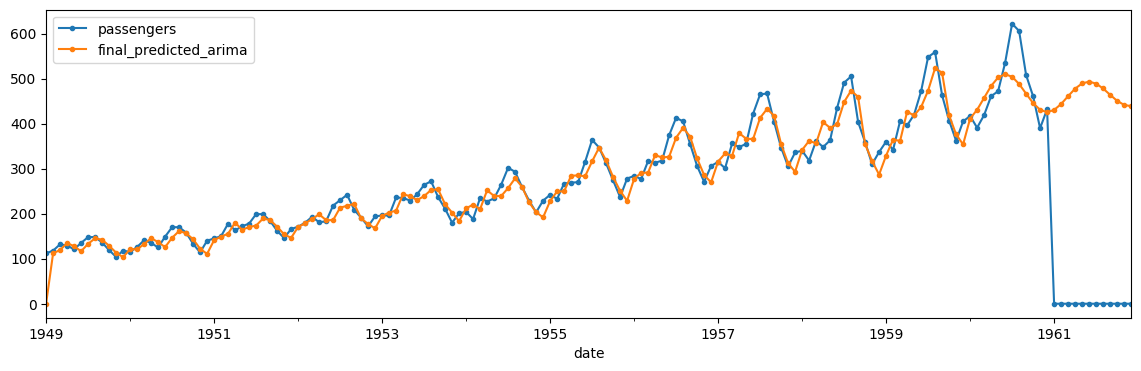

In [42]:
final_ts_df.loc[:,['passengers','final_predicted_arima']].plot(style='.-');

### 4.4 How to select p,d,q Values

There are 3 methods to select p,d,q values:

4.4.1. From ACF and PACF plot

4.4.2. Using Auto Arima 

4.4.3. custom for loop(Finding the ordr of p d,q by calculating the lowest RMSE)

**4.4.1. Finding the ordr of p d,q by using ACF and PACF plots**

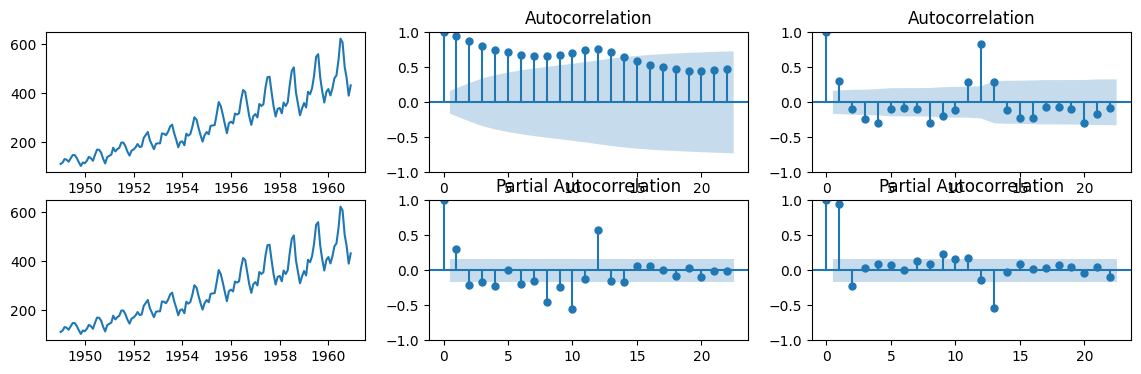

In [43]:
# Create subplots for ACF and PACF plots
fig,axes= plt.subplots(2, 3)
axes[0,0].plot(ts_df['passengers'])
# Plot ACF
plot_acf(ts_df['passengers'], ax= axes[0,1])
plot_acf(ts_df['passengers'].diff().dropna(), ax= axes[0,2])
axes[1,0].plot(ts_df['passengers'])
# Plot PACF
plot_pacf(ts_df['passengers'].diff().dropna(), ax= axes[1,1])
plot_pacf(ts_df['passengers'].dropna(), ax= axes[1,2])
plt.show()


Note:
1. In PACF plot we can see that the first lag is significantly out of the limit and the second one is also out of the significant limit, so we can select the order of the p as 2.

2. In ACF plot, we can see that 2 of the lags are out of the significance limit so we can say that the optimal value of our q (MA) is 2.

3. This is a classic method so sometimes its difficult to choose the correct order of p and q.

**4.4.2.Finding the ordr of p d,q by Using Auto Arima**

In [44]:
auto_arima(train, m=12, start_p=0,seasonal=True, d=1, trace=True, error_action='ignore', supress_warnings='True', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=905.065, Time=0.00 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=900.823, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=901.721, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=899.902, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=901.052, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=901.337, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=900.971, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=900.685, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=902.967, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=901.457, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.281 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

Note:
1. Auto ARIMA function choose the best model based on the lowest AIC and BIC values. For the model evaluation we fully not dependent on the criteria of lowest AIC and BIC values.
2. The model with lowest AIC and BIC values might not be the best model in terms of mean squarred error.
3. So in my openion using a custom for loop and calculate the lowest RMSE in all possible combination is the best method.

**4.4.3.Finding the ordr of p d,q by calculating the lowest RMSE**

In [45]:
p=range(0,4)
q=range(0,4)
d=range(0,2)
pdq_combination_list=list(itertools.product(p,d,q))

In [46]:
rmse=[]
order1=[]
for pdq in pdq_combination_list:
    try:
        model=ARIMA(train,order=pdq).fit()
        pred=model.predict(start=len(train),end=len(ts_df)-1)
        error=np.sqrt(mean_squared_error(test,pred))
        order1.append(pdq)
        rmse.append(error)
    except:
        continue

In [47]:
result=pd.DataFrame(index=order1,data=rmse,columns=['RMSE'])
result.RMSE.sort_values(ascending=True)[0:10]

(2, 1, 2)    55.222839
(3, 1, 3)    58.311242
(3, 0, 3)    60.451228
(3, 1, 1)    87.586273
(3, 1, 2)    87.779232
(2, 1, 1)    87.884377
(0, 1, 3)    89.142625
(3, 1, 0)    89.169784
(0, 1, 1)    89.662242
(0, 1, 2)    90.898775
Name: RMSE, dtype: float64

# 5. SARIMA Model

In [48]:
from itertools import product
from tqdm import tqdm_notebook
p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 52

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [49]:
def optimize_SARIMA(endog, parameters_list, d, D, s):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        endog - the observed variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(endog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)x(P,D,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [50]:
result=optimize_SARIMA(train, parameters_list, d, D, 12)

  0%|          | 0/16 [00:00<?, ?it/s]

In [51]:
result.head()

,"(p,d,q)x(P,D,Q)",AIC
0,"(1, 0, 0, 0)",899.901849
1,"(1, 0, 1, 1)",899.928610
2,"(0, 1, 0, 0)",900.684984
3,"(0, 1, 1, 1)",900.690573
4,"(1, 0, 1, 0)",900.822865


### 5.1 Fitting the best SARIMA Model with lowest AIC value

In [52]:
model = SARIMAX(ts_df['passengers'],order = (1,1,0),seasonal_order = (0,1,0,12))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -508.197
Date:                            Tue, 12 Dec 2023   AIC                           1020.393
Time:                                    00:30:35   BIC                           1026.144
Sample:                                01-01-1949   HQIC                          1022.730
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3076      0.073     -4.186      0.000      -0.452      -0.164
sigma2       137.0108     14.623   

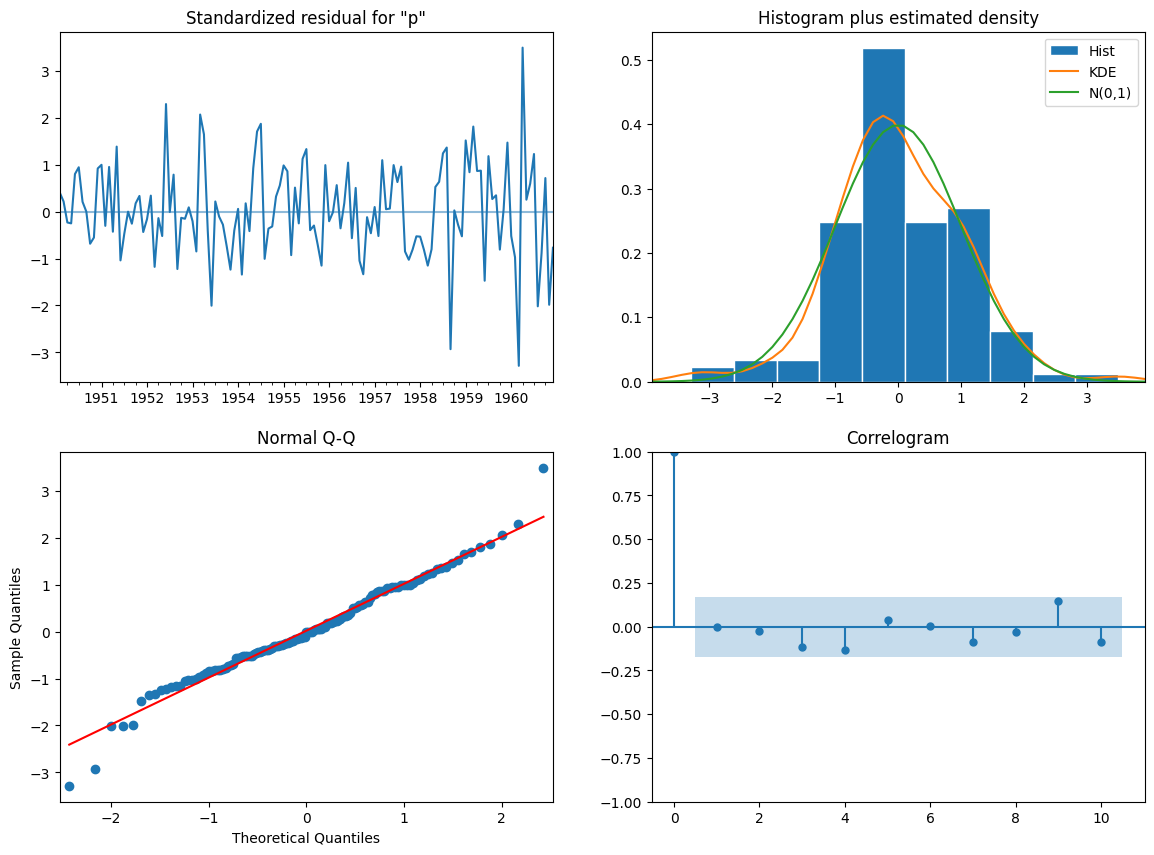

In [53]:
model_fit.plot_diagnostics(figsize=(14,10))
plt.show()

Observation:
1. The KDE plot of the residuals on the top right is almost similar with the normal distribution.
2. The qq-plot on the bottom left shows that the ordered distribution of residuals follows the linear trend and aligned
    with the diagonal line, this is a strong indication that the residuals are normally distributed.
3. The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is
   confirmed by the autocorrelation plot on the bottom right, which shows that the time series residuals have low 
   correlation with lagged versions of itself.

**5.1.1 Storing the predicted valuesby SARIMA Model**

In [54]:
# generating forecast for next year
n_forecast=11
model_fit.get_prediction(end=model.nobs + n_forecast)
predict =model_fit.get_prediction(end=model.nobs + n_forecast)
y_forecast=predict.predicted_mean 
final_ts_df['predicted_values_sarima']=y_forecast

In [55]:
final_ts_df.tail()

,passengers,predicted_arima,future_predicted_arima,final_predicted_arima,predicted_values_sarima
date,,,,,
1961-08-01,0,0.0,478.151562,478.151562,633.235226
1961-09-01,0,0.0,464.114420,464.114420,535.235251
1961-10-01,0,0.0,450.796531,450.796531,488.235244
1961-11-01,0,0.0,441.654468,441.654468,417.235246
1961-12-01,0,0.0,438.800922,438.800922,459.235245


**5.1.2 Calculating the Evaluation Matrices for SARIMA model****

**5.1.3 Calculating MSE and RMSE**

In [56]:
y_pred_sarima=final_ts_df['predicted_values_sarima'][132:144]
y_true_sarima=final_ts_df['passengers'][132:144]

In [57]:
mse = mean_squared_error(y_true_sarima, y_pred_sarima)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 411.70810845285064
Root Mean Squared Error: 20.290591624022465


**5.1.4 Calculating Min_Max accuracy and MAPE**

In [58]:
MIN_MAX_SARIMA=min_max_accuracy(y_true_sarima, y_pred_sarima)
MAPE_SARIMA=mape_accuracy(y_true_sarima, y_pred_sarima)

In [59]:
MIN_MAX_SARIMA

96.58108894856571

In [60]:
MAPE_SARIMA

3.500140822935411

**5.1.6 Visulization of actual,predicted and future prediction from both ARIMA and SARIMA model for next 12 months**

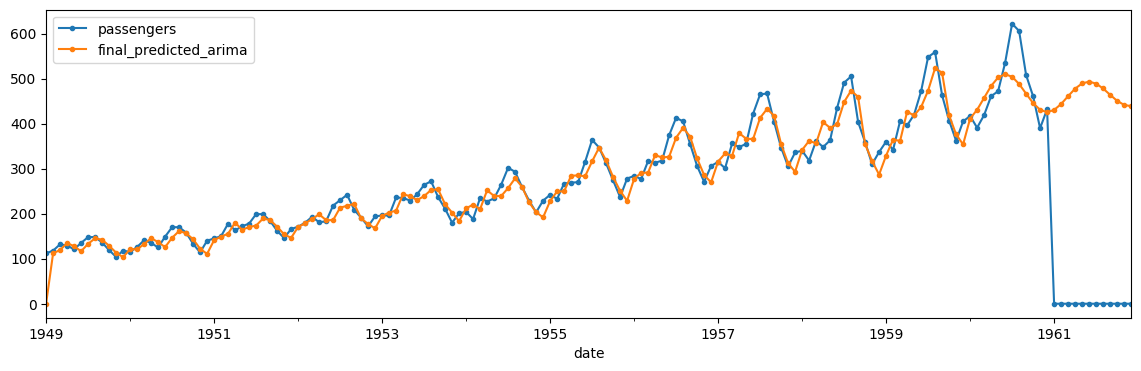

In [61]:
final_ts_df.loc[:,['passengers','final_predicted_arima']].plot(style='.-');

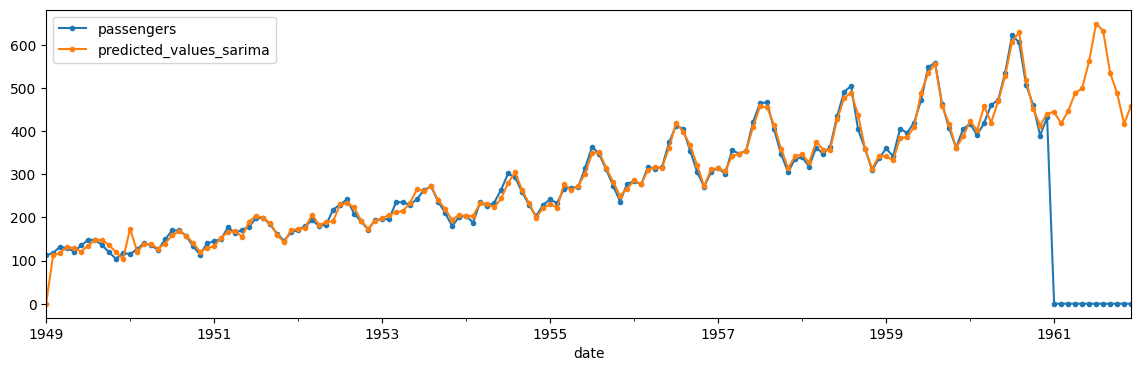

In [62]:
final_ts_df.loc[:,['passengers','predicted_values_sarima']].plot(style='.-');

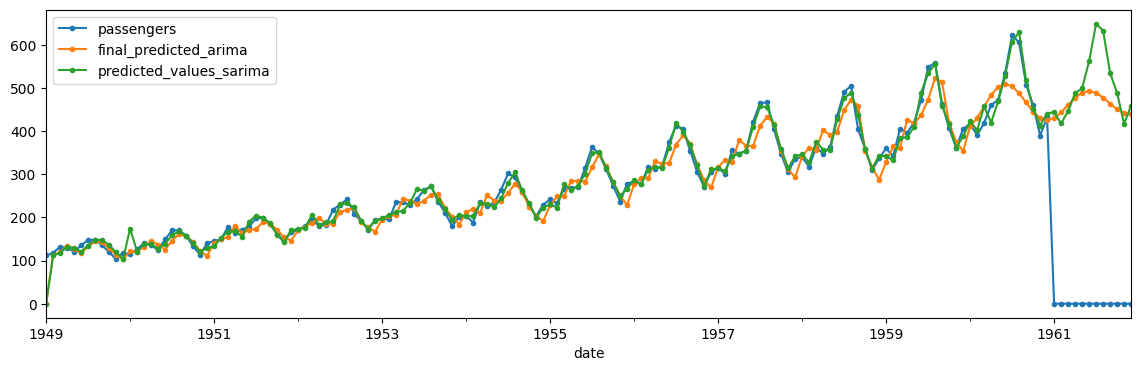

In [63]:
final_ts_df.loc[:,['passengers','final_predicted_arima','predicted_values_sarima']].plot(style='.-');

# 4. Model Evaluation



Here I have used 4 evaluation matrices,MSE, RMSE,MAPE and MIN_MaX_ACCURACY.

Evaluation Matrices         ARIMA Model   VS      SARIMA Model

MSE                         3049.56       VS      411.70  

RMSE                        55.22           VS     20.29

MAPE                        8.2205         VS      3.50

MIN_MaX_ACCURACY            92.05%         VS      96.58%


By comparing above matrices SARIMA model best fit for the data. Which is clear from the above plot as well.


# Conclusion

Here I have performed the following tasks:

1. EDA: In this section I have performed data pre-processing, checking for missing values,seasonal decompose of time series, checking for outliers( visual inspection and modified z-score method) as well as cyclic patterns. From the EDA analysis, the seasonality is clearly seen and the time series has trend as well so its not stationary time series.


2. Test for stationary: I used the statistical test called "Dickey-Fuller unit root test test". This test also shows that time series is not stationary.  Here I used three different transformations(first difference, log transformation and box-cox transformation) but the first  difference made the time series stationary.

3. Fitting the ARIMA and SARIMA model: I choose to fit the ARIMA and SARIMA model to compare the results from both the models. 


4. Compared the results from both the models: As we already detected the seasonality in the data SARIMA model fitted performed the best to the data.Also, the evaluation matrices from SARIMA model are way better than ARIMA model. One can easily see the results from the plot(in the section 5.1.6)

So, SARIMA model is best for this time series data. One can predict the future number of passangers more accurately by using SARIMA model.